<a href="https://colab.research.google.com/github/tomradch/MSCIDS_Computational_Language_Technologies/blob/main/5_0_intro_to_rnn_seq2seq_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Translation with Sequence-to-Sequence

In this notebook, we will address the problem of translation. Since 2014, the de facto architecture for this is what we call "sequence-to-sequence".

Given a document and a language, the goal is translate the document into the given language.

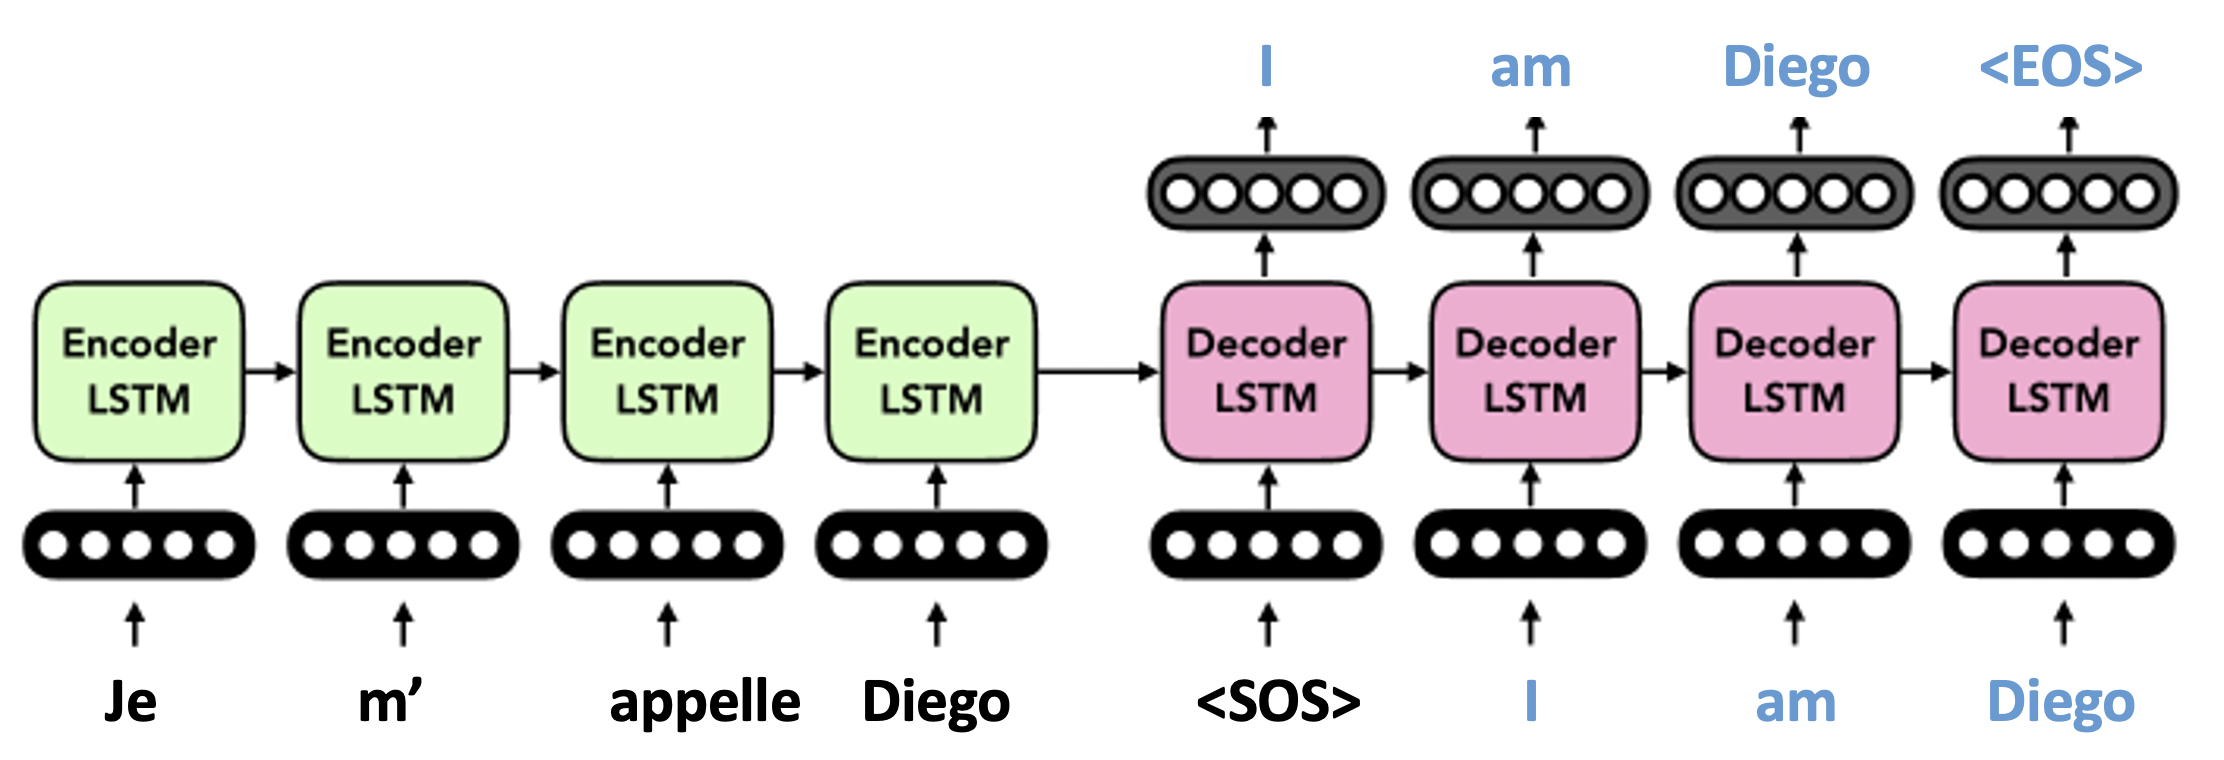

Before starting, let's verify that we have a GPU available. If not, please change the runtime type **Runtime -> change runtime type -> hardware accelerator -> GPU**.

In [ ]:
!nvidia-smi

Thu May 11 07:05:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Read and split data

We will use the data provided in the [NLP from Scratch tutorial of PyTorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). It consists of 135k paired-samples with English and French sentences. Let's download the dataset and see some examples

In [ ]:
!rm eng-fra.txt
!rm -rf names data
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!rm -rf names

rm: cannot remove 'eng-fra.txt': No such file or directory
--2023-05-11 07:05:03--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.250.24, 13.224.250.7, 13.224.250.5, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.250.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2023-05-11 07:05:04 (60.4 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  infla

In [ ]:
!ls

data  data.zip	sample_data


Let's filter out long sentences and do some preprocessing.

In [ ]:
# Let's load the data and do some preprocessing
import unicodedata
import re

MAX_LENGTH = 32 # To reduce the size of the dataset

# From https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def _normalize(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s

#Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )

data_original = []
with open('data/eng-fra.txt', 'r', encoding='utf-8') as fp:
    for line_id, line in enumerate(fp):
        line = line.strip()
        if len(line) > 2:
          en, fr = line.split('\t')
          en, fr = _normalize(en), _normalize(fr)

          if len(en) <= MAX_LENGTH and len(fr) <= MAX_LENGTH:
            data_original.append({'idx': line_id,
                             'en_text': en,
                             'fr_text': fr,
                             'en_word_idx': [],
                             'fr_word_idx': []})
len(data_original)

56662

In [ ]:
data_original

[{'idx': 0,
  'en_text': 'go .',
  'fr_text': 'va !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 1,
  'en_text': 'run !',
  'fr_text': 'cours !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 2,
  'en_text': 'run !',
  'fr_text': 'courez !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 3,
  'en_text': 'wow !',
  'fr_text': 'ca alors !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 4,
  'en_text': 'fire !',
  'fr_text': 'au feu !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 5,
  'en_text': 'help !',
  'fr_text': 'a l aide !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 6,
  'en_text': 'jump .',
  'fr_text': 'saute .',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 7,
  'en_text': 'stop !',
  'fr_text': 'ca suffit !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 8,
  'en_text': 'stop !',
  'fr_text': 'stop !',
  'en_word_idx': [],
  'fr_word_idx': []},
 {'idx': 9,
  'en_text': 'stop !',
  'fr_text': 'arrete toi !',
  'en_word_idx'

Before spliting the data into training, validation, and testing, it is a good practice to set all the random seeds for reproducibility purposes.

In [ ]:
import numpy as np
import math
import tqdm
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

In [ ]:
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# We make a deep copy of the reviews and shuffle the data for the train, val, test split!
data = copy.deepcopy(data_original)
random.shuffle(data)

# We define how to split the data
split_train = int(len(data) * 0.8)
split_val = (len(data) - split_train) // 2
split_test = len(data) - split_train - split_val

train_data = data[:split_train]
data = data[split_train:]

val_data = data[:split_val]
data = data[split_val:]

test_data = data

# Sanity check
assert len(train_data + val_data + test_data) == len(data_original)


As in the previous exercice, we will use the `Dataset` class and the `Dataloader` class to load efficiently the data, process the data if needed, and build batches automatically. 

During the dataset creation process, we need for each sample:

1. An input sentence (X)
2. The output sentence (the words to predict) (y)
3. Optionnally an ID to identify the sample
4. Optionnally whatever information you might find useful (e.g., the full text)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data
                
    # We return the length of the dataset
    def __len__(self):
        return len(self.data)

    # We return the idx'th sample
    def __getitem__(self, idx):
        return {
            'idx': idx,
            'en_word_idx': torch.tensor(self.data[idx]['en_word_idx']).long(),
            'fr_word_idx': torch.tensor(self.data[idx]['fr_word_idx']).long(),
        }

In [ ]:
train_data = TranslationDataset(train_data)
val_data = TranslationDataset(val_data)
test_data = TranslationDataset(test_data)

In [ ]:
len(train_data), len(val_data), len(test_data) 

(45329, 5666, 5667)

# Build the vocabulary and word embedding matrix

We now have all our data. Let's build the vocabulary and prepare the word-embeddings for the next steps **FOR EACH LANGUAGE**.

In [ ]:
vocabulary = {'en': set(), 'fr': set()}

for lang in ('en', 'fr'):
  for sample in train_data.data: # Pay attention we only use the training set!
    for token in sample['{}_text'.format(lang)].split(): # tokenize
      vocabulary[lang].add(token)
  print(lang, len(vocabulary[lang]))

en 6294
fr 10306


In this case, we do not have too many words so there is no need to filter/reduce the vocabulary (< 30k is usually good enough). Typically, we could use a frequency approach and removes words appearing less than X times.

In [ ]:
# Create the mappindg word - index and vice-versa
word2idx = {'en': {'_PAD_': 0, '_UNK_': 1, '_SOS_': 2, '_EOS_': 3}, 
            'fr': {'_PAD_': 0, '_UNK_': 1, '_SOS_': 2, '_EOS_': 3}}

idx2word = {'en': {}, 'fr': {}}
for lang in ('en', 'fr'):
  for word in vocabulary[lang]:
    word2idx[lang][word] = len(word2idx[lang])
  idx2word[lang] = {idx:word for word, idx in word2idx[lang].items()}
  print(word2idx[lang])

{'_PAD_': 0, '_UNK_': 1, '_SOS_': 2, '_EOS_': 3, 'choosy': 4, 'terror': 5, 'teams': 6, 'straws': 7, 'safely': 8, 'clubs': 9, 'harder': 10, 'bloom': 11, 'too': 12, 'kennel': 13, 'hotel': 14, 'seats': 15, 'stir': 16, 'hair': 17, 'monsoon': 18, 'interjection': 19, 'morning': 20, 'tighten': 21, 'fret': 22, 'growled': 23, 'piece': 24, 'double': 25, 'swedish': 26, 'clever': 27, 'blown': 28, 'judgment': 29, 'all': 30, 'divine': 31, 'apparently': 32, 'noises': 33, 'spared': 34, 'comparing': 35, 'lonely': 36, 'thrown': 37, 'charge': 38, 'tissue': 39, 'bonus': 40, 'sobbing': 41, 'solid': 42, 'war': 43, 'toilets': 44, 'cake': 45, 'introduced': 46, 'blind': 47, 'half': 48, 'make': 49, 'flaws': 50, 'nearly': 51, 'wait': 52, 'satisfied': 53, 'sofa': 54, 'annoyed': 55, 'serve': 56, 'collar': 57, 'street': 58, 'insane': 59, 'whatsoever': 60, 'drifted': 61, 'ask': 62, 'rises': 63, 'brokenhearted': 64, 'attack': 65, 'ketchup': 66, 'ambulance': 67, 'cheated': 68, 'negotiator': 69, 'heed': 70, 'joining': 

In [ ]:
idx2word['en']

{0: '_PAD_',
 1: '_UNK_',
 2: '_SOS_',
 3: '_EOS_',
 4: 'choosy',
 5: 'terror',
 6: 'teams',
 7: 'straws',
 8: 'safely',
 9: 'clubs',
 10: 'harder',
 11: 'bloom',
 12: 'too',
 13: 'kennel',
 14: 'hotel',
 15: 'seats',
 16: 'stir',
 17: 'hair',
 18: 'monsoon',
 19: 'interjection',
 20: 'morning',
 21: 'tighten',
 22: 'fret',
 23: 'growled',
 24: 'piece',
 25: 'double',
 26: 'swedish',
 27: 'clever',
 28: 'blown',
 29: 'judgment',
 30: 'all',
 31: 'divine',
 32: 'apparently',
 33: 'noises',
 34: 'spared',
 35: 'comparing',
 36: 'lonely',
 37: 'thrown',
 38: 'charge',
 39: 'tissue',
 40: 'bonus',
 41: 'sobbing',
 42: 'solid',
 43: 'war',
 44: 'toilets',
 45: 'cake',
 46: 'introduced',
 47: 'blind',
 48: 'half',
 49: 'make',
 50: 'flaws',
 51: 'nearly',
 52: 'wait',
 53: 'satisfied',
 54: 'sofa',
 55: 'annoyed',
 56: 'serve',
 57: 'collar',
 58: 'street',
 59: 'insane',
 60: 'whatsoever',
 61: 'drifted',
 62: 'ask',
 63: 'rises',
 64: 'brokenhearted',
 65: 'attack',
 66: 'ketchup',
 67: 'a

In [ ]:
idx2word['fr']

{0: '_PAD_',
 1: '_UNK_',
 2: '_SOS_',
 3: '_EOS_',
 4: 'manges',
 5: 'sembles',
 6: 'aneantis',
 7: 'clubs',
 8: 'repand',
 9: 'hotel',
 10: 'prete',
 11: 'frequentee',
 12: 'conta',
 13: 'ramene',
 14: 'chocolat',
 15: 'seront',
 16: 'gamin',
 17: 'actifs',
 18: 'troublant',
 19: 'marginalisee',
 20: 'survivantes',
 21: 'attendirent',
 22: 'gueri',
 23: 'investisseurs',
 24: 'ravissante',
 25: 'interjection',
 26: 'souffrance',
 27: 'aurez',
 28: 'goutte',
 29: 'amnesie',
 30: 'affreuse',
 31: 'habitudes',
 32: 'partes',
 33: 'procedez',
 34: 'suspicieuse',
 35: 'vetez',
 36: 'durera',
 37: 'baleine',
 38: 'colle',
 39: 'apprendre',
 40: 'supportez',
 41: 'consideres',
 42: 'existez',
 43: 'ni',
 44: 'piece',
 45: 'double',
 46: 'arrivames',
 47: 'spontanee',
 48: 'helvete',
 49: 'silencieux',
 50: 'infectees',
 51: 'divine',
 52: 'manipulateur',
 53: 'resserra',
 54: 'epique',
 55: 'merde',
 56: 'idee',
 57: 'vieillit',
 58: 'fatigues',
 59: 'charge',
 60: 'flaire',
 61: 'bonus',
 6

For simplicity, we will initialize word embedding matrices randomly! In practice, you can use different set of word embeddings for the input and output language embeddings.

In [ ]:
# Now we create the word embedding matrix randomly
WORD_DIM = 300

# Initialize randomly the word embedding matrix
word_embeddings = {'en': np.random.rand(len(word2idx['en']), WORD_DIM), 
                   'fr': np.random.rand(len(word2idx['fr']), WORD_DIM)}

# Set the values to 0 for padding
word_embeddings['en'][word2idx['en']['_PAD_']] = np.zeros(WORD_DIM)
word_embeddings['fr'][word2idx['fr']['_PAD_']] = np.zeros(WORD_DIM)

# Process the data.

Now, we can add the word embedding indeces to our data to be fed to the model. 

Let's use the attribute `word_idx` for all samples. In case a word is unknown, we will simply replace it with the work "_UNK_".

In [ ]:
# We add the word indeces to all data splits
for split_data in [train_data.data, val_data.data, test_data.data]:
  for lang in ['en', 'fr']:
    for sample in split_data:
      sample['{}_word_idx'.format(lang)] = []
      for token in sample['{}_text'.format(lang)].split():
        # If a word is not in our vocabulary, we put the UNK token instead
        sample['{}_word_idx'.format(lang)].append(word2idx[lang][token] if token in word2idx[lang] else word2idx[lang]['_UNK_'])

In [ ]:
train_data[0], train_data.data[0]

({'idx': 0,
  'en_word_idx': tensor([  91, 5148, 5674,  695, 2812, 1844, 3134]),
  'fr_word_idx': tensor([3485, 2674, 1452, 2840, 9902, 7264, 3847, 5680, 5178])},
 {'idx': 44125,
  'en_text': 'i m not afraid of death .',
  'fr_text': 'je n ai pas peur de la mort .',
  'en_word_idx': [91, 5148, 5674, 695, 2812, 1844, 3134],
  'fr_word_idx': [3485, 2674, 1452, 2840, 9902, 7264, 3847, 5680, 5178]})

Great! We are nearly there. The last problem to address is to have the same length for the sentences. A simple way is to pad each sample until reaching the maximum length.

In our case, we will pad to `MAX_LENGTH` tokens.

Finally, we will also add two special tokens: `_SOS_` (start-of-sequence) and `_EOS_` (end-of-sequence). `_SOS_` will be the prefix of every sentences and `_EOS_` the suffix. The idea is to indicate the model that the sentence starts or ends at this position. It helps the model greatly in modeling the semantics. Refer to the image in the first cell if you do not remember

In [ ]:
for lang in ['en', 'fr']:
  for split_data in [train_data.data, val_data.data, test_data.data]:
    for sample in split_data:

      # Add _SOS_ and _EOS_ tokens!
      sample['{}_word_idx'.format(lang)] = [word2idx[lang]['_SOS_']] + sample['{}_word_idx'.format(lang)] + [word2idx[lang]['_EOS_']]

      # Pad
      while len(sample['{}_word_idx'.format(lang)]) < (MAX_LENGTH + 2): # + 2 because of SOS and EOS
        sample['{}_word_idx'.format(lang)].append(word2idx[lang]['_PAD_'])
      
      # Sanity check
      assert len(sample['{}_word_idx'.format(lang)]) == (MAX_LENGTH + 2)

In [ ]:
train_data[0]

{'idx': 0,
 'en_word_idx': tensor([   2,   91, 5148, 5674,  695, 2812, 1844, 3134,    3,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'fr_word_idx': tensor([   2, 3485, 2674, 1452, 2840, 9902, 7264, 3847, 5680, 5178,    3,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0])}

# Modeling

Could you explain what are we modeling?

In [ ]:
class TranslationModel(nn.Module):
    def __init__(self, dropout, hidden_dim, words_num_src, words_num_des, word_dim):
        super(TranslationModel, self).__init__()

        # ENCODER
        self.src_word_embedding = nn.Embedding(num_embeddings=words_num_src, embedding_dim=word_dim)
        self.encoder = nn.GRU(input_size=word_dim,
                               hidden_size=hidden_dim,
                               num_layers=2, # Let's add an extra-layer
                               batch_first=True,
                               dropout=0, # No dropout; it is complicated for RNNs. Do you have an intuition why?
                               bidirectional=True) # Let's assume bi-directional
        
        # DECODER
        self.des_word_embedding = nn.Embedding(num_embeddings=words_num_des, embedding_dim=word_dim)
        self.decoder = nn.GRU(input_size=word_dim,
                               hidden_size=hidden_dim,
                               num_layers=1, # Here we keep it simple
                               batch_first=True,
                               dropout=0, # No dropout; it is complicated for RNNs. Do you have an intuition why?
                               bidirectional=False) # ATTENTION: we cannot have bidirectionality here!
        # The last layer to compute the probabilities for the output classes
        self.final_layer = nn.Linear(in_features=hidden_dim, out_features=words_num_des)

        # BONUS: How would you implement the attention component?

        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Tanh()
        
        
    def forward(self, x_src, len_src, x_des, len_des, last_hidden=None):
        if last_hidden is None: # It means we have already encoded the input sentence and we are generated the output. This is a trick to not recompute at each decoding step the latent representation of the input sentence.
          ################
          # ENCODING PART#
          ################

          x_src = self.src_word_embedding(x_src)
          x_src = self.dropout(x_src)
          
          # PyTorch (and other frameworks) are using CuDNN for efficient neural networks.
          # For some reason, for LSTM, GRU, and RNN, the input sequences MUST be sorted by decreasing length
          # Therefore, we will do it manually before feeding the network AND also after in order to have the hidden vectors in the right order

          # 1. We sort the batch (and keep the sorting index) according to their sequencelength in decreasing order
          sorted_lengths, sorted_order = len_src.sort(0, descending=True)
          sorted_input = x_src[sorted_order] # Here we rearrange the batch
          _, invert_order = sorted_order.sort(0, descending=False) # We store the indeces of the sorting

          # 2. Because all sequences DO NOT have the same length, we might not want to waste GPU resources on useless computation.
          # For example:
          # a) I     am       Diego PAD  PAD
          # b) Ciao  ragazzi  PAD   PAD  PAD
          # c) We    are      doing deep learning
          # 
          # Only c) needs to process the full sequence. In a) and b), only 3 and 2 steps are needed.
          # pack_padded_sequence will exactly help us and not compute 15 "operations" but only 10 in total. Here we save already ~33% of the GPU!
          prepared_input = nn.utils.rnn.pack_padded_sequence(sorted_input, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)

          # If you check the documentation https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
          # hidden and cell (useless) will be the final hidden/cell state (NbDirection xBxH) 
          # whereas output contains the values of the hidden states for each time step (NbDirection xBxLxH)
          _, hidden = self.encoder(prepared_input)# Bidirectional*nblayers x B x H
          
          # We aggregate into one vector
          hidden = torch.sum(hidden, dim=0)

          # 3. We sort back the hidden vectors
          hidden = hidden.index_select(0, invert_order)          
          hidden = self.dropout(self.activation(hidden))
          hidden = hidden.unsqueeze(0)

          # Hidden is now our latent representation of our input sentence!
        else:
          hidden = last_hidden
        
        #################
        # DECODING PART #
        #################

        # We will be using Teacher-Focring, meaning that we will provide to the model the previous REAL words as input.
        # Hence, we need to encode the output sequence as well.
        # At inference (as we will see later), we will generate the output text in an auto-regressive manner, where is word has been predicted.
        x_des = self.des_word_embedding(x_des)
        x_des = self.dropout(x_des)

        sorted_lengths, sorted_order = len_des.sort(0, descending=True)
        sorted_input = x_des[sorted_order] # Here we rearrange the batch
        _, invert_order = sorted_order.sort(0, descending=False) # We store the indeces of the sorting
        hidden = hidden[:, sorted_order] # Pay attention: we have also to sort it!
                
        prepared_input = nn.utils.rnn.pack_padded_sequence(sorted_input, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)
        # We will parallelize and predict ALL next tokens in once step.
        # The most important here is to provide the context to initialize the hidden states
        output, new_last_hidden = self.decoder(prepared_input, hidden)

        # We unpack the output and reorder all hidden states.
        output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=torch.max(len_des) if last_hidden is None else 1)[0] #BxLxH
        output = output.index_select(0, invert_order)

        new_last_hidden = new_last_hidden.index_select(1, invert_order)
        output = self.dropout(self.activation(output))

        # Compute the log probabilities. We do not compute the probabilities with Softmax because depending the loss function, we might require unnormalized or probabilities.
        # Worst case, we can always apply F.softmax(output, dim=-1) later.
        word_logits = self.final_layer(output)
        return word_logits, new_last_hidden

Let's see if our model can compute a foward pass

In [ ]:
x_src = torch.tensor([[1,2,3,4,5,0], [10,20,30,40,0,0], [5,6,0,0,0,0]])
len_src = torch.sum(x_src != 0, dim=1)
x_des = x_src[:, 1:]
len_des = len_src - 1

In [ ]:
x_src, len_src

(tensor([[ 1,  2,  3,  4,  5,  0],
         [10, 20, 30, 40,  0,  0],
         [ 5,  6,  0,  0,  0,  0]]),
 tensor([5, 4, 2]))

In [ ]:
x_des, len_des

(tensor([[ 2,  3,  4,  5,  0],
         [20, 30, 40,  0,  0],
         [ 6,  0,  0,  0,  0]]),
 tensor([4, 3, 1]))

In [ ]:
translator = TranslationModel(dropout=0.1, hidden_dim=24, words_num_src=50, words_num_des=50, word_dim=12)
logits, last_hidden = translator(x_src, len_src, x_des, len_des)
logits, logits.size(), last_hidden.size()

(tensor([[[ 7.0946e-02,  1.8270e-01,  1.1369e-01,  1.4958e-01,  2.8110e-02,
            2.2634e-01,  1.2713e-02,  3.0825e-01, -4.8444e-01, -1.1362e-01,
            2.5104e-01,  7.4229e-02,  1.6561e-01,  2.4883e-03, -6.1863e-02,
            2.0518e-02, -1.0992e-01,  2.3432e-01,  9.7835e-02, -3.7266e-01,
            4.8402e-02, -1.6725e-01,  1.2586e-02, -2.1086e-01,  1.7871e-01,
            2.5846e-01,  1.1262e-01,  3.4478e-01,  1.1535e-01, -2.5898e-01,
            3.5374e-01, -3.2672e-01, -6.3701e-02, -4.1694e-01, -4.3081e-02,
            2.5746e-01,  6.6177e-02, -1.1578e-01,  1.1648e-01,  9.3252e-02,
           -8.0353e-02, -2.0052e-02, -1.4071e-01,  7.1731e-02,  3.2159e-01,
            3.0349e-02, -9.6051e-03,  2.5669e-03, -1.5729e-01,  8.7764e-02],
          [ 1.2079e-01,  1.8161e-01,  1.1327e-02,  7.2552e-02, -1.2333e-01,
            7.3084e-02, -6.4113e-02,  1.8542e-01, -5.3381e-01, -6.5512e-02,
            2.9753e-01, -2.2139e-01,  8.1073e-02,  1.9807e-02, -1.1500e-01,
           

Great! The model seems to work and is able to compute the word probability for each word!

# Putting all together

We now have the model, the data, and the loss function. We are ready to implement the training loop.

In [ ]:
BATCH_SIZE = 128
SRC = 'en'
DES = 'fr'

# We initialize our model
model = TranslationModel(dropout=0.1, 
                         hidden_dim=128, 
                         words_num_src=len(word2idx[SRC]), 
                         words_num_des=len(word2idx[DES]), 
                         word_dim=WORD_DIM)

# Copy the word embedding matrix
model.src_word_embedding.weight.data = torch.from_numpy(word_embeddings[SRC]).float()
model.src_word_embedding.weight.requires_grad = True

# Copy the word embedding matrix
model.des_word_embedding.weight.data = torch.from_numpy(word_embeddings[DES]).float()
model.des_word_embedding.weight.requires_grad = True

In [ ]:
# We initialize our optimizer to update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

In [ ]:
# We can load our dataset using a dataloader
train_loader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        shuffle=True, # Pay attention that we can shuffle the samples for training
        num_workers=0, # And specify how many working we want. 0/1 = 1
        drop_last=False) # Finally, it is possible to drop the last batch if its size is smaller than args.batch_size. In some applications, it is easier to ignore it instead of handling it.

val_loader = DataLoader(
        val_data,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

test_loader = DataLoader(
        test_data,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

In [ ]:
# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize the loss function
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=0)

best_epoch = 0
best_val_so_far = float('inf')
test_perf = 0


# TRAINING LOOP
for epoch in range(50):
  print('------------------------------------------------------------------------')
  print('Epoch: {}'.format(epoch))

  # TRAIN
  # We set the model in train mode. It will store information to compute the gradients
  # Also, the implementation of dropout, batchnorm, etc is different at training and inference time.
  model.train()

  train_losses = []
  # Pay attention how the data loading become easiers!
  for idx, batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):
    # Prepare data
    x_src = batch['{}_word_idx'.format(SRC)]
    len_src = torch.sum(x_src != 0, dim=1)
    x_des = batch['{}_word_idx'.format(DES)]
    len_des = torch.sum(x_des != 0, dim=1)

    # Move to GPU
    x_src = x_src.to(device)
    len_src = len_src.to(device)
    x_des = x_des.to(device)
    len_des = len_des.to(device)

    # Compute the model output and the loss
    y_logits, last_hidden = model(x_src, len_src, x_des, len_des)
    y_preds = y_logits
    y_gold = x_des[:, 1:y_preds.size(1)+1].contiguous()

    # We have to "flatten" the predictions because CE only handle tensors like BxC and B
    loss = criterion(y_preds.view(y_preds.size(0)*y_preds.size(1), -1), y_gold.view(-1))
    ppl = math.exp(loss)

    # Update model parameters
    optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
    loss.backward() # Now that gradients have been empties, we compute the new ones using the loss.
    clip_grad_norm_(model.parameters(), 3.0) # PAY ATTENTION: Protection against gradient exploding
    optimizer.step() # We do gradient update with our optimization function (i.e., the weights of the model are updated).
  
    train_losses.append(loss.item())
  
  # VAL + TEST
  val_test_losses = {'val': [], 'test': []}
  val_test_ppl = {'val': [], 'test': []}
  
  # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
  model.eval()

  # We do not store information relative to gradients as we do not update the model.
  # That's the reason why inference requires less memory and is faster.
  with torch.no_grad():
    for split_data, data in [('val', val_loader), ('test', test_loader)]:
      # Pay attention how the data loading become easiers!
      for idx, batch in tqdm.tqdm(enumerate(data), desc=split_data.capitalize()):
        # Prepare data
        x_src = batch['{}_word_idx'.format(SRC)]
        len_src = torch.sum(x_src != 0, dim=1)
        x_des = batch['{}_word_idx'.format(DES)]
        len_des = torch.sum(x_des != 0, dim=1)

        # Move to GPU
        x_src = x_src.to(device)
        len_src = len_src.to(device)
        x_des = x_des.to(device)
        len_des = len_des.to(device)

        # Compute the model output and the loss
        y_logits, last_hidden = model(x_src, len_src, x_des, len_des) #BxLxC (17)
        y_preds = y_logits
        y_gold = x_des[:, 1:y_preds.size(1)+1].contiguous()

        # We have to "flatten" the predictions because CE only handle tensors like BxC and B
        loss = criterion(y_preds.view(y_preds.size(0)*y_preds.size(1), -1), y_gold.view(-1))
        ppl = math.exp(loss)

        val_test_losses[split_data].append(loss.item())
        val_test_ppl[split_data].append(ppl)
  
  # Monitoring
  print('Train loss: {:.4f}'.format(np.mean(train_losses)))
  print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
  print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
  print()

  val_ppl = np.mean(val_test_ppl['val'])
  test_ppl = np.mean(val_test_ppl['test'])
  print('Val   PPL: {:.4f}'.format(val_ppl))
  print('Test  PPL: {:.4f}'.format(test_ppl))
  print()

  if val_ppl < best_val_so_far:
    best_val_so_far = val_ppl
    test_perf = test_ppl
    best_epoch = epoch
    torch.save(model.state_dict(), 'my_model.ckpt')
  
  print('Best Epoch: {}, best val PPL: {:.4f}, test PPL: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
  print()
  print()

------------------------------------------------------------------------
Epoch: 0


Training: 355it [00:07, 46.41it/s]
Val: 45it [00:00, 132.26it/s]
Test: 45it [00:00, 140.02it/s]


Train loss: 4.8469
Val   loss: 4.2432
Test  loss: 4.2314

Val   PPL: 69.8203
Test  PPL: 68.9684

Best Epoch: 0, best val PPL: 69.8203, test PPL: 68.9684


------------------------------------------------------------------------
Epoch: 1


Training: 355it [00:07, 49.35it/s]
Val: 45it [00:00, 142.19it/s]
Test: 45it [00:00, 135.61it/s]


Train loss: 3.8505
Val   loss: 3.4770
Test  loss: 3.4659

Val   PPL: 32.4752
Test  PPL: 32.0824

Best Epoch: 1, best val PPL: 32.4752, test PPL: 32.0824


------------------------------------------------------------------------
Epoch: 2


Training: 355it [00:06, 51.55it/s]
Val: 45it [00:00, 92.36it/s]
Test: 45it [00:00, 95.03it/s]


Train loss: 3.2275
Val   loss: 3.0626
Test  loss: 3.0531

Val   PPL: 21.4665
Test  PPL: 21.2437

Best Epoch: 2, best val PPL: 21.4665, test PPL: 21.2437


------------------------------------------------------------------------
Epoch: 3


Training: 355it [00:06, 53.47it/s]
Val: 45it [00:00, 132.78it/s]
Test: 45it [00:00, 140.62it/s]


Train loss: 2.8750
Val   loss: 2.7926
Test  loss: 2.7838

Val   PPL: 16.3844
Test  PPL: 16.2350

Best Epoch: 3, best val PPL: 16.3844, test PPL: 16.2350


------------------------------------------------------------------------
Epoch: 4


Training: 355it [00:07, 49.40it/s]
Val: 45it [00:00, 137.48it/s]
Test: 45it [00:00, 137.64it/s]


Train loss: 2.6152
Val   loss: 2.6090
Test  loss: 2.5967

Val   PPL: 13.6446
Test  PPL: 13.4709

Best Epoch: 4, best val PPL: 13.6446, test PPL: 13.4709


------------------------------------------------------------------------
Epoch: 5


Training: 355it [00:06, 53.46it/s]
Val: 45it [00:00, 138.28it/s]
Test: 45it [00:00, 137.83it/s]


Train loss: 2.4040
Val   loss: 2.4534
Test  loss: 2.4445

Val   PPL: 11.6794
Test  PPL: 11.5716

Best Epoch: 5, best val PPL: 11.6794, test PPL: 11.5716


------------------------------------------------------------------------
Epoch: 6


Training: 355it [00:07, 49.68it/s]
Val: 45it [00:00, 141.81it/s]
Test: 45it [00:00, 136.95it/s]


Train loss: 2.2378
Val   loss: 2.3410
Test  loss: 2.3324

Val   PPL: 10.4392
Test  PPL: 10.3458

Best Epoch: 6, best val PPL: 10.4392, test PPL: 10.3458


------------------------------------------------------------------------
Epoch: 7


Training: 355it [00:07, 49.04it/s]
Val: 45it [00:00, 136.20it/s]
Test: 45it [00:00, 137.01it/s]


Train loss: 2.0963
Val   loss: 2.2448
Test  loss: 2.2374

Val   PPL: 9.4836
Test  PPL: 9.4109

Best Epoch: 7, best val PPL: 9.4836, test PPL: 9.4109


------------------------------------------------------------------------
Epoch: 8


Training: 355it [00:07, 50.15it/s]
Val: 45it [00:00, 136.96it/s]
Test: 45it [00:00, 143.12it/s]


Train loss: 1.9800
Val   loss: 2.1754
Test  loss: 2.1712

Val   PPL: 8.8493
Test  PPL: 8.8121

Best Epoch: 8, best val PPL: 8.8493, test PPL: 8.8121


------------------------------------------------------------------------
Epoch: 9


Training: 355it [00:07, 49.40it/s]
Val: 45it [00:00, 135.93it/s]
Test: 45it [00:00, 132.29it/s]


Train loss: 1.8725
Val   loss: 2.1096
Test  loss: 2.1043

Val   PPL: 8.2900
Test  PPL: 8.2433

Best Epoch: 9, best val PPL: 8.2900, test PPL: 8.2433


------------------------------------------------------------------------
Epoch: 10


Training: 355it [00:06, 51.27it/s]
Val: 45it [00:00, 93.70it/s]
Test: 45it [00:00, 96.53it/s]


Train loss: 1.7778
Val   loss: 2.0484
Test  loss: 2.0425

Val   PPL: 7.7971
Test  PPL: 7.7481

Best Epoch: 10, best val PPL: 7.7971, test PPL: 7.7481


------------------------------------------------------------------------
Epoch: 11


Training: 355it [00:06, 52.86it/s]
Val: 45it [00:00, 139.33it/s]
Test: 45it [00:00, 137.88it/s]


Train loss: 1.6934
Val   loss: 2.0001
Test  loss: 1.9930

Val   PPL: 7.4304
Test  PPL: 7.3767

Best Epoch: 11, best val PPL: 7.4304, test PPL: 7.3767


------------------------------------------------------------------------
Epoch: 12


Training: 355it [00:07, 48.74it/s]
Val: 45it [00:00, 136.39it/s]
Test: 45it [00:00, 129.61it/s]


Train loss: 1.6153
Val   loss: 1.9550
Test  loss: 1.9518

Val   PPL: 7.1058
Test  PPL: 7.0783

Best Epoch: 12, best val PPL: 7.1058, test PPL: 7.0783


------------------------------------------------------------------------
Epoch: 13


Training: 355it [00:06, 53.24it/s]
Val: 45it [00:00, 137.19it/s]
Test: 45it [00:00, 128.64it/s]


Train loss: 1.5432
Val   loss: 1.9167
Test  loss: 1.9107

Val   PPL: 6.8394
Test  PPL: 6.7946

Best Epoch: 13, best val PPL: 6.8394, test PPL: 6.7946


------------------------------------------------------------------------
Epoch: 14


Training: 355it [00:07, 49.28it/s]
Val: 45it [00:00, 139.28it/s]
Test: 45it [00:00, 125.23it/s]


Train loss: 1.4766
Val   loss: 1.8810
Test  loss: 1.8739

Val   PPL: 6.6003
Test  PPL: 6.5507



KeyboardInterrupt: ignored

# Decoding at inference: greedy decoding

All good. We have trained our model which achieves a good perplexity. However, if you remember, we have been using teach-forcing during training. This means that we have never generated text in an auto-regressive manner.

There are many ways to do this. However, we will keep it simple by using a method called "greedy decoding" (which is still actively used). Here is the idea as shown in the course.

For more, a nice introduction is available [here](https://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture12-generation-final.pdf).

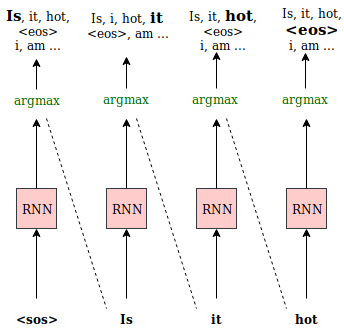

[Source](https://towardsdatascience.com/word-sequence-decoding-in-seq2seq-architectures-d102000344ad)

Basically, we will encode the whole sentence and give as input to the decoding the latent representation and the **SOS** token. The model will output the word distribution for the next word and we choose the most likely with greedy decoding. In the example, the word would be *Is*. Then, we continue and give to the decoder the input `[SOS, Is]` and repeat.

When do we stop decoding? Either when we encounter the **EOS** token, which means the model believes the sentence is over, or when we reach the maximum number of steps.

Let's see in practice!

In [ ]:
# We load our best model
model = TranslationModel(dropout=0.1, 
                         hidden_dim=128, 
                         words_num_src=len(word2idx[SRC]), 
                         words_num_des=len(word2idx[DES]), 
                         word_dim=WORD_DIM)
model.load_state_dict(torch.load('my_model.ckpt'))
model.to(device)

In [ ]:
translated_data = []
with torch.no_grad():
    for idx, batch in tqdm.tqdm(enumerate(test_loader), desc=split_data.capitalize()):
      # Prepare data
      x_src = batch['{}_word_idx'.format(SRC)]
      y_des = batch['{}_word_idx'.format(DES)]
      len_src = torch.sum(x_src != 0, dim=1)

      # We create our decoding vector, that is initialized with the SOS token
      x_des = torch.ones(x_src.size(0)).long().unsqueeze(1) * word2idx[DES]['_SOS_']
      len_des = torch.ones(x_src.size(0)).long() # The decoding step is one because we have only one token as input

      # Move to GPU
      x_src = x_src.to(device)
      len_src = len_src.to(device)
      x_des = x_des.to(device)
      len_des = len_des.to(device)

      last_hidden = None
      generated_tokens = []
      for time_step in range(MAX_LENGTH):
        # Compute the model output and the loss
        y_logits, last_hidden = model(x_src, len_src, x_des, len_des, last_hidden)
        next_word_val, next_word_idx = y_logits.topk(1) # We take the most likely next token. Bx1x1

        # Prepare the next input, which is the most likely word
        x_des = next_word_idx.squeeze(2)
        generated_tokens.append(x_des.cpu())
        # ATTENTION: it would be tempted to concatenated it to x_des and increment len_des.
        # However, in doing so, we will recompute the hidden states for all words, which is not computationally efficient.
      
      # Map word_idx to text
      texts = []

      x_src = x_src.cpu()[:, 1:].numpy() # Ignore the _SOS_token
      y_des = y_des.cpu()[:, 1:].numpy()
      x_des = torch.concat(generated_tokens, dim=1).numpy()

      #print(x_des)

      for idx, word_indeces in enumerate(x_src):
        # Store the input sentence
        tokens = []
        for word_id in word_indeces:
          if word_id in {word2idx[SRC]['_EOS_'], word2idx[SRC]['_PAD_']}:
            break
          tokens.append(idx2word[SRC][word_id])
        texts.append([' '.join(tokens)])
      
        # Add the predicted translation
        word_indeces = x_des[idx]
        tokens = []
        for word_id in word_indeces:
          if word_id in {word2idx[DES]['_EOS_'], word2idx[DES]['_PAD_']}:
            break
          tokens.append(idx2word[DES][word_id])
        texts[-1].append(' '.join(tokens))
    
        # Add the gold translation
        word_indeces = y_des[idx]
        tokens = []
        for word_id in word_indeces:
          if word_id in {word2idx[DES]['_EOS_'], word2idx[DES]['_PAD_']}:
            break
          tokens.append(idx2word[DES][word_id])
        texts[-1].append(' '.join(tokens))

      # Store the translation into our global variable
      translated_data += texts

Let's see how does our model translate!

In [ ]:
for idx in range(10):
  print('Idx: {}'.format(idx))
  print('SRC: {}'.format(translated_data[idx][0]))
  print('DES: {}'.format(translated_data[idx][1]))
  print('Gold: {}'.format(translated_data[idx][2]))
  print()
  print()

# BLEU: default metric for machine translation

The BiLingual Evaluation Understudy (BLEU) compares the produced translation w.r.t. one or more human-written translations. It computes a similarity score based on n-gram precision and a penalty for too-short system translations.

BLEU is clearly not bulletproof but gives you one indicator about the quality of your translation. However, it is important to understand that here "quality" refers to the number of n-gram overlaps.

Let's see how does our system perform.

In [ ]:
translated_data[:10]

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Prepare the data to compare predicted and reference translations
references = [[gold] for _, pred, gold in translated_data] # Only one reference sentence
candidates = [pred for _, pred, gold in translated_data]

In [ ]:
references[:5]

In [ ]:
candidates[:5]

In [ ]:
bleu = sentence_bleu(references, candidates)
print('BLEU: {:.2f}'.format(100 * bleu))

An overall BLEU score of 50 seems good if you look at current research. However, **it is not comparable!**. Current machine translation are evaluated on million of data with complex sentences. In our case, we used only small and simple sentences! Actually, our score is pretty low.

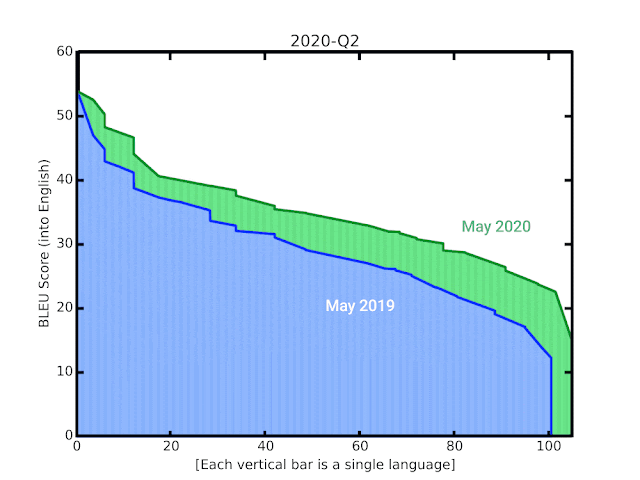